Test Metrics:
MSE: 0.8089
RMSE: 0.8994
MAE: 0.7413
R²: 0.9525


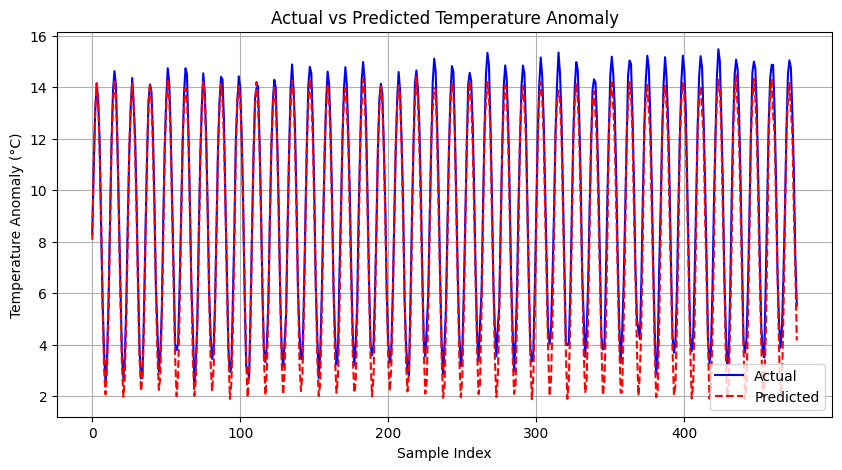


Sample trend directions (first 20 points):
Step 0: N/A
Step 1: Rising
Step 2: Rising
Step 3: Rising
Step 4: Decreasing
Step 5: Decreasing
Step 6: Decreasing
Step 7: Decreasing
Step 8: Decreasing
Step 9: Decreasing
Step 10: Rising
Step 11: Rising
Step 12: Rising
Step 13: Rising
Step 14: Rising
Step 15: Rising
Step 16: Decreasing
Step 17: Decreasing
Step 18: Decreasing
Step 19: Decreasing

Sample alerts (first 20 points):
Step 0: Activate Temperature Warning
Step 1: Activate Temperature Warning
Step 2: Activate Temperature Warning
Step 3: Activate Temperature Warning
Step 4: Activate Temperature Warning
Step 5: Activate Temperature Warning
Step 6: Activate Temperature Warning
Step 7: Activate Temperature Warning
Step 8: Activate Temperature Warning
Step 9: Activate Temperature Warning
Step 10: Activate Temperature Warning
Step 11: Activate Temperature Warning
Step 12: Activate Temperature Warning
Step 13: Activate Temperature Warning
Step 14: Activate Temperature Warning
Step 15: Activa

In [1]:
# 03_model_evaluation.ipynb
# Task 2e: Model Evaluation and Predictions for SCADA GUI

# --- Import Libraries ---
import os
import sys
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib

sys.path.append(os.path.abspath(".."))
from utils.data_loader import load_and_preprocess

# --- Load Preprocessed Test Data ---
X_train, X_val, X_test, y_train, y_val, y_test, scaler_X, scaler_y = load_and_preprocess(
    path='../data/raw_data.csv', lags=5
)

X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# --- Define Model Architecture ---
class TempPredictor(nn.Module):
    def __init__(self, input_dim):
        super(TempPredictor, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
    def forward(self, x):
        return self.net(x)

# --- Load Trained Model ---
model = TempPredictor(input_dim=X_test.shape[1])
model.load_state_dict(torch.load('../models/temp_predictor.pth'))
model.eval()

# --- Load Scalers ---
scaler_X = joblib.load('../models/scaler_X.pkl')
scaler_y = joblib.load('../models/scaler_y.pkl')

# --- Make Predictions ---
with torch.no_grad():
    y_pred_scaled = model(X_test).numpy()
    X_test_np = X_test.numpy()

# Inverse transform predictions and actual values
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_actual = scaler_y.inverse_transform(y_test.numpy())

# --- Compute Evaluation Metrics ---
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(y_actual, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_actual, y_pred)
r2 = r2_score(y_actual, y_pred)

print(f"Test Metrics:\nMSE: {mse:.4f}\nRMSE: {rmse:.4f}\nMAE: {mae:.4f}\nR²: {r2:.4f}")

# --- Plot Actual vs Predicted ---
plt.figure(figsize=(10,5))
plt.plot(y_actual, label='Actual', color='blue')
plt.plot(y_pred, label='Predicted', color='red', linestyle='--')
plt.xlabel('Sample Index')
plt.ylabel('Temperature Anomaly (°C)')
plt.title('Actual vs Predicted Temperature Anomaly')
plt.legend()
plt.grid(True)
plt.show()

# --- Trend Direction Calculation ---
# Define rising, stable, decreasing trend using simple delta threshold
delta_threshold = 0.02  # temperature change per step considered significant
trend = []

for i in range(1, len(y_pred)):
    diff = y_pred[i] - y_pred[i-1]
    if diff > delta_threshold:
        trend.append("Rising")
    elif diff < -delta_threshold:
        trend.append("Decreasing")
    else:
        trend.append("Stable")

# Add first element as None for alignment
trend = ["N/A"] + trend

# Show first 20 trend values as example
print("\nSample trend directions (first 20 points):")
for i, t in enumerate(trend[:20]):
    print(f"Step {i}: {t}")

# --- Alert Signal ---
alert_threshold = 1.5  # °C anomaly threshold for alert
alerts = ["Activate Temperature Warning" if val > alert_threshold else "Safe" for val in y_pred.flatten()]

# Show first 20 alerts as example
print("\nSample alerts (first 20 points):")
for i, a in enumerate(alerts[:20]):
    print(f"Step {i}: {a}")
